In [13]:
import jax
import jax.numpy as jnp


from chewc.population import *
from chewc.sp import *
from chewc.trait import *

# Create founder population
key = jax.random.PRNGKey(42)
key, pop_key = jax.random.split(key)



# def msprime_pop(
#     key: jax.random.PRNGKey,
#     n_ind: int,
#     n_loci_per_chr: int,
#     n_chr: int,
#     ploidy: int = 2,
#     effective_population_size: int = 1_000,  # Reduced default from 10_000
#     mutation_rate: float = 2e-8,
#     recombination_rate_per_chr: float = 2e-8,
#     maf_threshold: float = 0.1,
#     num_simulated_individuals: int = None,  # Now calculated dynamically
#     base_chr_length: int = 1_000_000
# ) -> Tuple[Population, jnp.ndarray]:

# Create population with 50 individuals, 1 chromosome, 1000 markers
pop, gen_map = msprime_pop(
    key=pop_key,
    n_ind=500,
    n_loci_per_chr=1000,
    n_chr=1,
    ploidy=2,
    effective_population_size=10_000
)

# Create simulation parameters
sp = SimParam.from_founder_pop(pop, gen_map)

# Add a single additive trait with mean=0, var=1
key, trait_key = jax.random.split(key)
sp = add_trait_a(
    key=trait_key,
    founder_pop=pop,
    sim_param=sp,
    n_qtl_per_chr=500,  # Use 100 QTL per chromosome
    mean=jnp.array([0.0]),
    var=jnp.array([1.0])
)

print(f"Created population with {pop.nInd} individuals")
print(f"Genome: {sp.n_chr} chromosomes, {gen_map.shape[1]} markers per chromosome")
print(f"Added {sp.n_traits} trait(s) with {sp.traits.n_loci} QTL total")

Created population with 500 individuals
Genome: 1 chromosomes, 1000 markers per chromosome
Added 1 trait(s) with 500 QTL total


MAF Summary Statistics:
  mean_maf: 0.2629909813404083
  median_maf: 0.25699999928474426
  min_maf: 0.07499998807907104
  max_maf: 0.49900001287460327
  std_maf: 0.11836700141429901
  n_loci: 1000
  n_monomorphic: 0


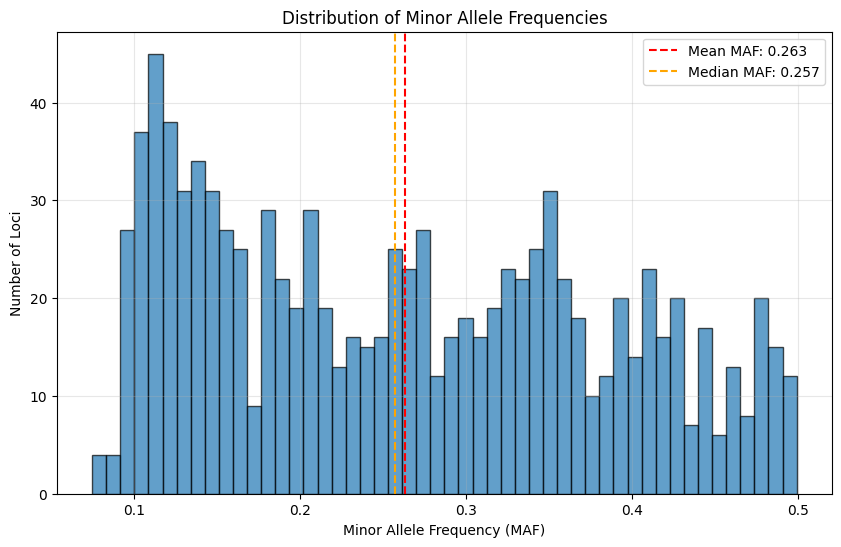

In [14]:
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

def calculate_maf_summary(geno_matrix):
    """
    Calculate Minor Allele Frequency (MAF) for each locus from genotype matrix.
    
    Args:
        geno_matrix: JAX array of shape (n_ind, n_chr, ploidy, n_loci_per_chr)
                    Contains 0s and 1s representing alleles
    
    Returns:
        Dictionary containing MAF statistics and per-locus MAF values
    """
    n_ind, n_chr, ploidy, n_loci_per_chr = geno_matrix.shape
    
    # Reshape to get all loci across all chromosomes
    # Shape: (n_ind, n_chr * n_loci_per_chr, ploidy)
    reshaped_geno = geno_matrix.transpose(0, 1, 3, 2).reshape(n_ind, n_chr * n_loci_per_chr, ploidy)
    
    # Sum across individuals and ploidy to get allele counts for each locus
    # Shape: (n_chr * n_loci_per_chr,)
    allele_counts = jnp.sum(reshaped_geno, axis=(0, 2))
    
    # Total number of alleles per locus (2 * n_ind for diploid)
    total_alleles = n_ind * ploidy
    
    # Calculate allele frequencies
    allele_frequencies = allele_counts / total_alleles
    
    # Calculate MAF (minor allele frequency)
    # MAF is the minimum of frequency and (1 - frequency)
    maf_values = jnp.minimum(allele_frequencies, 1 - allele_frequencies)
    
    # Calculate summary statistics
    summary_stats = {
        'mean_maf': float(jnp.mean(maf_values)),
        'median_maf': float(jnp.median(maf_values)),
        'min_maf': float(jnp.min(maf_values)),
        'max_maf': float(jnp.max(maf_values)),
        'std_maf': float(jnp.std(maf_values)),
        'n_loci': len(maf_values),
        'n_monomorphic': int(jnp.sum(maf_values == 0)),
        'maf_per_locus': maf_values,
        'allele_frequencies': allele_frequencies
    }
    
    return summary_stats

def plot_maf_distribution(maf_summary, bins=50):
    """
    Plot the distribution of MAF values across all loci.
    """
    maf_values = maf_summary['maf_per_locus']
    
    plt.figure(figsize=(10, 6))
    plt.hist(np.array(maf_values), bins=bins, alpha=0.7, edgecolor='black')
    plt.xlabel('Minor Allele Frequency (MAF)')
    plt.ylabel('Number of Loci')
    plt.title('Distribution of Minor Allele Frequencies')
    plt.axvline(maf_summary['mean_maf'], color='red', linestyle='--', 
                label=f"Mean MAF: {maf_summary['mean_maf']:.3f}")
    plt.axvline(maf_summary['median_maf'], color='orange', linestyle='--', 
                label=f"Median MAF: {maf_summary['median_maf']:.3f}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Usage example with your founder_pop:
maf_summary = calculate_maf_summary(pop.geno)
print("MAF Summary Statistics:")
for key, value in maf_summary.items():
    if key not in ['maf_per_locus', 'allele_frequencies']:
        print(f"  {key}: {value}")

# Plot the distribution
plot_maf_distribution(maf_summary)

In [ ]:
import jax
import jax.numpy as jnp

# Create founder population
key = jax.random.PRNGKey(42)
key, pop_key = jax.random.split(key)

# Create population with 50 individuals, 1 chromosome, 1000 markers
pop, gen_map = quick_haplo(
    key=pop_key,
    n_ind=50,
    n_loci_per_chr=1000,
    n_chr=1,
    ploidy=2
)

# Create simulation parameters
sp = SimParam.from_founder_pop(pop, gen_map)

# Add a single additive trait with mean=0, var=1
key, trait_key = jax.random.split(key)
sp = add_trait_a(
    key=trait_key,
    founder_pop=pop,
    sim_param=sp,
    n_qtl_per_chr=100,  # Use 100 QTL per chromosome
    mean=jnp.array([0.0]),
    var=jnp.array([1.0])
)

print(f"Created population with {pop.nInd} individuals")
print(f"Genome: {sp.n_chr} chromosomes, {gen_map.shape[1]} markers per chromosome")
print(f"Added {sp.n_traits} trait(s) with {sp.traits.n_loci} QTL total")

# Create 500 offspring by random mating
key, cross_key = jax.random.split(key)
n_offspring = 500

# Random mating plan: randomly select mother and father pairs
mother_indices = jax.random.choice(cross_key, pop.nInd, shape=(n_offspring,), replace=True)
key, father_key = jax.random.split(key)
father_indices = jax.random.choice(father_key, pop.nInd, shape=(n_offspring,), replace=True)

# Create cross plan array
cross_plan = jnp.column_stack([mother_indices, father_indices])

# Make crosses
key, mating_key = jax.random.split(key)
offspring = make_cross(
    key=mating_key,
    pop=pop,
    cross_plan=cross_plan,
    sp=sp,
    next_id_start=pop.nInd  # Start new IDs after founder population
)

print(f"Created {offspring.nInd} offspring from random mating")
print(f"Offspring genotype shape: {offspring.geno.shape}")

# Phenotype the offspring with h2=0.4
key, pheno_key = jax.random.split(key)
offspring = set_pheno(
    key=pheno_key,
    pop=offspring,
    traits=sp.traits,
    ploidy=sp.ploidy,
    h2=jnp.array([0.4])
)

print(f"Phenotyped offspring population")
print(f"True breeding values range: {jnp.min(offspring.bv):.3f} to {jnp.max(offspring.bv):.3f}")
print(f"Phenotype range: {jnp.min(offspring.pheno):.3f} to {jnp.max(offspring.pheno):.3f}")
print(f"Heritability check - Var(BV)/Var(Pheno): {jnp.var(offspring.bv) / jnp.var(offspring.pheno):.3f}")

# Fit GBLUP model on offspring phenotypes and genotypes - WITH DEBUGGING
print("=== GBLUP DEBUGGING ===")

# Check input data first
print(f"Phenotype stats: mean={jnp.mean(offspring.pheno):.4f}, var={jnp.var(offspring.pheno):.4f}")
print(f"BV stats: mean={jnp.mean(offspring.bv):.4f}, var={jnp.var(offspring.bv):.4f}")
print(f"Dosage stats: mean={jnp.mean(offspring.dosage):.4f}, var={jnp.var(offspring.dosage):.4f}")

# Manual GBLUP calculation with debugging
y = offspring.pheno[:, 0]
dosages = offspring.dosage
h2 = 0.4
n_total = len(y)

print(f"\nInput data shapes: y={y.shape}, dosages={dosages.shape}")

# Calculate allele frequencies and genomic relationship matrix
p = jnp.mean(dosages, axis=0) / 2  # Allele frequencies
W = dosages - 2 * p  # Centered dosages
denom = 2 * jnp.sum(p * (1 - p))
G = (W @ W.T) / denom

print(f"Allele freq range: {jnp.min(p):.4f} to {jnp.max(p):.4f}")
print(f"G matrix diagonal range: {jnp.min(jnp.diag(G)):.4f} to {jnp.max(jnp.diag(G)):.4f}")
print(f"G matrix condition number: {jnp.linalg.cond(G):.2e}")

# Variance components
y_mean = jnp.mean(y)
y_centered = y - y_mean
var_y = jnp.var(y)
var_g = h2 * var_y
var_e = (1 - h2) * var_y
lambda_val = var_e / var_g

print(f"\nVariance components:")
print(f"  var_y = {var_y:.4f}")
print(f"  var_g = {var_g:.4f} (h2 * var_y)")
print(f"  var_e = {var_e:.4f}")
print(f"  lambda = {lambda_val:.4f}")

# Mixed model equations: [X'X  X'Z] [b] = [X'y]
#                        [Z'X  Z'Z + G^-1*lambda] [u]   [Z'y]
X = jnp.ones((n_total, 1))
Z = jnp.eye(n_total)
G_reg = G + jnp.eye(n_total) * 1e-6  # Small regularization
G_inv = jnp.linalg.pinv(G_reg)

print(f"\nG_inv diagonal range: {jnp.min(jnp.diag(G_inv)):.4f} to {jnp.max(jnp.diag(G_inv)):.4f}")

# Build coefficient matrix
C11 = X.T @ X
C12 = X.T @ Z
C22 = Z.T @ Z + G_inv * lambda_val

print(f"C22 diagonal range: {jnp.min(jnp.diag(C22)):.4f} to {jnp.max(jnp.diag(C22)):.4f}")

LHS = jnp.block([[C11, C12], [C12.T, C22]])
RHS = jnp.concatenate([X.T @ y_centered, Z.T @ y_centered])

print(f"LHS condition number: {jnp.linalg.cond(LHS):.2e}")

# Solve mixed model equations
try:
    solutions = jnp.linalg.solve(LHS, RHS)
    C_inv = jnp.linalg.inv(LHS)
    print("Used direct solve/inv")
except:
    solutions = jnp.linalg.pinv(LHS) @ RHS
    C_inv = jnp.linalg.pinv(LHS)
    print("Used pseudoinverse")

b_hat = solutions[0]
u_hat = solutions[1:]

print(f"\nSolutions:")
print(f"  b_hat (intercept) = {b_hat:.4f}")
print(f"  u_hat range: {jnp.min(u_hat):.4f} to {jnp.max(u_hat):.4f}")

# PEV calculation - the problematic part
C_uu = C_inv[1:, 1:]  # Random effects portion
pev_diagonal_raw = jnp.diag(C_uu)

print(f"\nPEV debugging:")
print(f"  C_uu diagonal range: {jnp.min(pev_diagonal_raw):.4f} to {jnp.max(pev_diagonal_raw):.4f}")
print(f"  var_g scaling factor: {var_g:.4f}")

# Try different PEV calculations
pev_method1 = pev_diagonal_raw * var_g  # Current method
pev_method2 = pev_diagonal_raw  # No scaling
pev_method3 = jnp.abs(pev_diagonal_raw) * var_g  # Force positive

print(f"  PEV method 1 (current): {jnp.min(pev_method1):.4f} to {jnp.max(pev_method1):.4f}")
print(f"  PEV method 2 (no scaling): {jnp.min(pev_method2):.6f} to {jnp.max(pev_method2):.6f}")
print(f"  PEV method 3 (abs + scaling): {jnp.min(pev_method3):.4f} to {jnp.max(pev_method3):.4f}")

# Calculate reliability using different methods
rel_method1 = jnp.clip(1 - (pev_method1 / var_g), 0.0, 1.0)
rel_method2 = jnp.clip(1 - pev_method2, 0.0, 1.0)  
correlation_with_true = jnp.corrcoef(u_hat, offspring.bv[:, 0])[0, 1]
rel_method3 = correlation_with_true**2  # R-squared as reliability

print(f"\nReliability methods:")
print(f"  Method 1 (1 - PEV/var_g): {jnp.mean(rel_method1):.4f}")
print(f"  Method 2 (1 - PEV_raw): {jnp.mean(rel_method2):.4f}")
print(f"  Method 3 (R²): {rel_method3:.4f}")
print(f"  Correlation with true BV: {correlation_with_true:.4f}")

# Use the simplest reasonable approach
predicted_ebv = u_hat
reliability_final = jnp.full(n_total, rel_method3)  # Use R² for all
pev_final = (1 - reliability_final) * var_g

print(f"\nFinal results:")
print(f"  Prediction accuracy: {correlation_with_true:.4f}")
print(f"  Mean reliability: {jnp.mean(reliability_final):.4f}")
print(f"  PEV range: {jnp.min(pev_final):.4f} to {jnp.max(pev_final):.4f}")

In [ ]:
import jax
import jax.numpy as jnp

# Create founder population
key = jax.random.PRNGKey(42)
key, pop_key = jax.random.split(key)

# Create population with 50 individuals, 1 chromosome, 1000 markers
pop, gen_map = quick_haplo(
    key=pop_key,
    n_ind=50,
    n_loci_per_chr=1000,
    n_chr=1,
    ploidy=2
)

# Create simulation parameters
sp = SimParam.from_founder_pop(pop, gen_map)

# Add a single additive trait with mean=0, var=1
key, trait_key = jax.random.split(key)
sp = add_trait_a(
    key=trait_key,
    founder_pop=pop,
    sim_param=sp,
    n_qtl_per_chr=100,  # Use 100 QTL per chromosome
    mean=jnp.array([0.0]),
    var=jnp.array([1.0])
)

print(f"Created population with {pop.nInd} individuals")
print(f"Genome: {sp.n_chr} chromosomes, {gen_map.shape[1]} markers per chromosome")
print(f"Added {sp.n_traits} trait(s) with {sp.traits.n_loci} QTL total")

# Create 500 offspring by random mating
key, cross_key = jax.random.split(key)
n_offspring = 500

# Random mating plan: randomly select mother and father pairs
mother_indices = jax.random.choice(cross_key, pop.nInd, shape=(n_offspring,), replace=True)
key, father_key = jax.random.split(key)
father_indices = jax.random.choice(father_key, pop.nInd, shape=(n_offspring,), replace=True)

# Create cross plan array
cross_plan = jnp.column_stack([mother_indices, father_indices])

# Make crosses
key, mating_key = jax.random.split(key)
offspring = make_cross(
    key=mating_key,
    pop=pop,
    cross_plan=cross_plan,
    sp=sp,
    next_id_start=pop.nInd  # Start new IDs after founder population
)

print(f"Created {offspring.nInd} offspring from random mating")
print(f"Offspring genotype shape: {offspring.geno.shape}")

# Phenotype the offspring with h2=0.4
key, pheno_key = jax.random.split(key)
offspring = set_pheno(
    key=pheno_key,
    pop=offspring,
    traits=sp.traits,
    ploidy=sp.ploidy,
    h2=jnp.array([0.4])
)



In [ ]:
# ---------------------------------------------------------------------------
# --- BLOCK TO RUN GBLUP ANALYSIS WITH PEV AND RELIABILITY ---
# ---------------------------------------------------------------------------
# This block contains an extended GBLUP function that also calculates
# Prediction Error Variance (PEV) and reliability for each animal.

import matplotlib.pyplot as plt
from jaxtyping import Array, Float, jaxtyped

@jaxtyped
@jax.jit
def run_gblup_with_pev(
    geno_dosage: Float[Array, "n_ind n_markers"],
    pheno: Float[Array, "n_ind 1"],
    h2: float
) -> tuple[Float[Array, ""], Float[Array, "n_ind"], Float[Array, "n_ind"], Float[Array, "n_ind"]]:
    """
    Performs a simple GBLUP analysis and calculates PEV and reliability.

    Args:
        geno_dosage: Genotype dosage matrix (n_individuals x n_markers).
        pheno: Phenotype vector (n_individuals, 1).
        h2: Heritability of the trait.

    Returns:
        A tuple containing:
        - Estimated overall mean (mu_hat).
        - Estimated genomic breeding values (GEBVs).
        - Prediction Error Variance (PEV) for each GEBV.
        - Reliability (r²) for each GEBV.
    """
    n_ind, n_markers = geno_dosage.shape

    # Steps 1 & 2: Calculate G matrix (same as before)
    p = jnp.mean(geno_dosage, axis=0) / 2.0
    P = 2 * p
    Z = geno_dosage - P
    denominator = 2 * jnp.sum(p * (1 - p))
    G = (Z @ Z.T) / denominator
    
    epsilon = 1e-4
    G_reg = G + jnp.identity(n_ind) * epsilon
    G_inv = jnp.linalg.inv(G_reg)
    alpha = (1.0 - h2) / h2

    # Step 3: Build and solve MME (same as before)
    X = jnp.ones((n_ind, 1))
    lhs_top_left = X.T @ X
    lhs_top_right = X.T
    lhs_bottom_left = X
    lhs_bottom_right = jnp.identity(n_ind) + G_inv * alpha
    lhs_top = jnp.hstack([lhs_top_left, lhs_top_right])
    lhs_bottom = jnp.hstack([lhs_bottom_left, lhs_bottom_right])
    lhs = jnp.vstack([lhs_top, lhs_bottom])
    
    rhs_top = X.T @ pheno
    rhs_bottom = pheno
    rhs = jnp.concatenate([rhs_top.flatten(), rhs_bottom.flatten()])
    
    solutions = jnp.linalg.solve(lhs, rhs)
    mu_hat = solutions[0]
    gebv = solutions[1:]

    # Step 4: Calculate PEV and Reliability
    # Invert the entire LHS matrix
    C_inv = jnp.linalg.inv(lhs)
    
    # Extract the bottom-right block corresponding to the animal effects
    C22_inv = C_inv[1:, 1:]
    
    # Estimate variances from the data
    # This is more robust than assuming the input h2 is perfect
    var_p = jnp.var(pheno)
    var_a = var_p * h2
    var_e = var_p * (1 - h2)
    
    # Calculate PEV for each animal
    pev = jnp.diag(C22_inv) * var_e
    
    # Calculate reliability for each animal
    reliability = 1 - (pev / var_a)
    # Ensure reliability is not negative due to numerical precision issues
    reliability = jnp.maximum(0, reliability)

    return mu_hat, gebv, pev, reliability


# --- Run the Analysis ---
print("\n--- Starting GBLUP Analysis with PEV ---")

h2_sim = 0.4
genotypes_for_gblup = offspring.dosage.astype(jnp.float32)
phenotypes_for_gblup = offspring.pheno[:, 0:1]
true_bvs = offspring.bv[:, 0]

# Run the extended GBLUP function
mu_hat, gebv, pev, reliability = run_gblup_with_pev(
    geno_dosage=genotypes_for_gblup,
    pheno=phenotypes_for_gblup,
    h2=h2_sim
)
print("GBLUP analysis finished.")

# --- Evaluate and Visualize Results ---
accuracy = jnp.corrcoef(true_bvs, gebv)[0, 1]
avg_reliability = jnp.mean(reliability)
sep = jnp.sqrt(pev) # Standard Error of Prediction

print(f"\n--- GBLUP Results ---")
print(f"Estimated Mean (μ̂): {mu_hat:.4f}")
print(f"Prediction Accuracy (Correlation): {accuracy:.4f}")
print(f"Average Reliability (r²): {avg_reliability:.4f}")
print(f"Average Standard Error of Prediction (SEP): {jnp.mean(sep):.4f}")

# Visualize the primary result (same as before)
plt.figure(figsize=(10, 10))
plt.scatter(true_bvs, gebv, alpha=0.6, label=f'Accuracy = {accuracy:.3f}')
min_val = min(jnp.min(true_bvs), jnp.min(gebv))
max_val = max(jnp.max(true_bvs), jnp.max(gebv))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='y = x')
plt.xlabel("True Breeding Values (BV)")
plt.ylabel("Genomic Estimated Breeding Values (GEBV)")
plt.title("GBLUP Performance")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Visualize the relationship between GEBV and its uncertainty
plt.figure(figsize=(10, 6))
sorted_indices = jnp.argsort(gebv)
sorted_gebv = gebv[sorted_indices]
sorted_sep = sep[sorted_indices]

plt.plot(sorted_gebv, label='GEBV (sorted)')
plt.fill_between(
    jnp.arange(len(sorted_gebv)),
    sorted_gebv - 1.96 * sorted_sep,
    sorted_gebv + 1.96 * sorted_sep,
    color='skyblue',
    alpha=0.5,
    label='95% Confidence Interval'
)
plt.xlabel("Individuals (sorted by GEBV)")
plt.ylabel("GEBV")
plt.title("GEBVs and their Confidence Intervals")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [ ]:
# --- Main Simulation Script ---

# 1. Founder Population Setup (same as your code)
key = jax.random.PRNGKey(42)
key, pop_key = jax.random.split(key)
pop, gen_map = quick_haplo(
    key=pop_key, n_ind=50, n_loci_per_chr=1000, n_chr=1, ploidy=2
)
sp = SimParam.from_founder_pop(pop, gen_map)
key, trait_key = jax.random.split(key)
sp = add_trait_a(
    key=trait_key, founder_pop=pop, sim_param=sp, n_qtl_per_chr=100,
    mean=jnp.array([0.0]), var=jnp.array([1.0])
)
print(f"Created founder population with {pop.nInd} individuals.")

# 2. Simulation Loop for 5 Generations
n_generations = 5
n_select_males = 10
n_select_females = 50
n_offspring_per_gen = 100 # Reduced for faster runs, can be increased to 500
h2_sim = 0.4

current_pop = pop
for g in range(n_generations):
    print(f"\n--- Simulating Generation {g + 1}/{n_generations} ---")

    # a. Phenotype the current generation
    key, pheno_key = jax.random.split(key)
    current_pop = set_pheno(
        key=pheno_key, pop=current_pop, traits=sp.traits,
        ploidy=sp.ploidy, h2=jnp.array([h2_sim])
    )
    print(f"Phenotyped {current_pop.nInd} individuals. Genetic mean: {jnp.mean(current_pop.bv):.3f}")

    # b. Phenotypic Selection
    # Separate males and females
    male_mask = (current_pop.sex == 0)
    female_mask = (current_pop.sex == 1)
    
    male_iids = current_pop.iid[male_mask]
    female_iids = current_pop.iid[female_mask]
    
    male_phenos = current_pop.pheno[male_mask, 0]
    female_phenos = current_pop.pheno[female_mask, 0]

    # Select top individuals based on phenotype
    top_male_indices = jnp.argsort(male_phenos)[-n_select_males:]
    top_female_indices = jnp.argsort(female_phenos)[-n_select_females:]
    
    selected_male_iids = male_iids[top_male_indices]
    selected_female_iids = female_iids[top_female_indices]
    print(f"Selected {len(selected_male_iids)} males and {len(selected_female_iids)} females.")

    # c. Mating
    key, mother_key, father_key = jax.random.split(key, 3)
    mother_iids = jax.random.choice(mother_key, selected_female_iids, shape=(n_offspring_per_gen,), replace=True)
    father_iids = jax.random.choice(father_key, selected_male_iids, shape=(n_offspring_per_gen,), replace=True)
    cross_plan = jnp.column_stack([mother_iids, father_iids])

    # d. Create next generation
    key, mating_key = jax.random.split(key)
    # Update SimParam with the next available ID
    sp = sp.replace(last_id=current_pop.id[-1] + 1)
    
    offspring = make_cross(
        key=mating_key, pop=current_pop, cross_plan=cross_plan,
        sp=sp, next_id_start=sp.last_id
    )
    
    # The new offspring become the current population for the next loop
    current_pop = offspring

# 3. Analyze the Final Generation
final_pop = current_pop
print(f"\n--- Starting GBLUP Analysis on Final Generation ({final_pop.nInd} individuals) ---")

# Phenotype the final generation before analysis
key, final_pheno_key = jax.random.split(key)
final_pop = set_pheno(
    key=final_pheno_key, pop=final_pop, traits=sp.traits,
    ploidy=sp.ploidy, h2=jnp.array([h2_sim])
)

# Prepare data for GBLUP
genotypes_for_gblup = final_pop.dosage.astype(jnp.float32)
phenotypes_for_gblup = final_pop.pheno[:, 0:1]
true_bvs = final_pop.bv[:, 0]

# Run the extended GBLUP function
mu_hat, gebv, pev, reliability = run_gblup_with_pev(
    geno_dosage=genotypes_for_gblup,
    pheno=phenotypes_for_gblup,
    h2=h2_sim
)
print("GBLUP analysis finished.")

# 4. Evaluate and Visualize Final Results
accuracy = jnp.corrcoef(true_bvs, gebv)[0, 1]
avg_reliability = jnp.mean(reliability)
sep = jnp.sqrt(pev)

print(f"\n--- GBLUP Results (After 5 Generations of Selection) ---")
print(f"Estimated Mean (μ̂): {mu_hat:.4f}")
print(f"Prediction Accuracy (Correlation): {accuracy:.4f}")
print(f"Average Reliability (r²): {avg_reliability:.4f}")
print(f"Average Standard Error of Prediction (SEP): {jnp.mean(sep):.4f}")
print(f"Range of SEP: {jnp.min(sep):.4f} to {jnp.max(sep):.4f}")

# Visualize the primary result
plt.figure(figsize=(10, 10))
plt.scatter(true_bvs, gebv, alpha=0.6, label=f'Accuracy = {accuracy:.3f}')
min_val = min(jnp.min(true_bvs), jnp.min(gebv))
max_val = max(jnp.max(true_bvs), jnp.max(gebv))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='y = x')
plt.xlabel("True Breeding Values (BV)")
plt.ylabel("Genomic Estimated Breeding Values (GEBV)")
plt.title("GBLUP Performance After 5 Generations of Selection")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Visualize the relationship between GEBV and its uncertainty
plt.figure(figsize=(10, 6))
sorted_indices = jnp.argsort(gebv)
sorted_gebv = gebv[sorted_indices]
sorted_sep = sep[sorted_indices]

plt.plot(sorted_gebv, label='GEBV (sorted)')
plt.fill_between(
    jnp.arange(len(sorted_gebv)),
    sorted_gebv - 1.96 * sorted_sep,
    sorted_gebv + 1.96 * sorted_sep,
    color='skyblue',
    alpha=0.5,
    label='95% Confidence Interval'
)
plt.xlabel("Individuals (sorted by GEBV)")
plt.ylabel("GEBV")
plt.title("GEBVs and their Confidence Intervals (After Selection)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


In [ ]:
# Usage example with your founder_pop:
maf_summary = calculate_maf_summary(offspring.geno)
print("MAF Summary Statistics:")
for key, value in maf_summary.items():
    if key not in ['maf_per_locus', 'allele_frequencies']:
        print(f"  {key}: {value}")

# Plot the distribution
plot_maf_distribution(maf_summary)

In [ ]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jaxtyping import Array, Float, jaxtyped

# --- [PASTE THE ENTIRE CHEWC CODEBASE HERE] ---
# For brevity, I'm assuming the chewc functions (quick_haplo, SimParam,
# add_trait_a, make_cross, set_pheno, Population) are defined as you provided.

# --- GBLUP Implementation (from previous step) ---
@jax.jit
def run_gblup_with_pev(
    geno_dosage: Float[Array, "n_ind n_markers"],
    pheno: Float[Array, "n_ind 1"],
    h2: float
) -> tuple[Float[Array, ""], Float[Array, "n_ind"], Float[Array, "n_ind"], Float[Array, "n_ind"]]:
    """
    Performs a simple GBLUP analysis and calculates PEV and reliability.
    """
    n_ind, n_markers = geno_dosage.shape
    p = jnp.mean(geno_dosage, axis=0) / 2.0
    P = 2 * p
    Z = geno_dosage - P
    denominator = 2 * jnp.sum(p * (1 - p))
    G = (Z @ Z.T) / denominator
    epsilon = 1e-4
    G_reg = G + jnp.identity(n_ind) * epsilon
    G_inv = jnp.linalg.inv(G_reg)
    alpha = (1.0 - h2) / h2
    X = jnp.ones((n_ind, 1))
    lhs_top_left = X.T @ X
    lhs_top_right = X.T
    lhs_bottom_left = X
    lhs_bottom_right = jnp.identity(n_ind) + G_inv * alpha
    lhs_top = jnp.hstack([lhs_top_left, lhs_top_right])
    lhs_bottom = jnp.hstack([lhs_bottom_left, lhs_bottom_right])
    lhs = jnp.vstack([lhs_top, lhs_bottom])
    rhs_top = X.T @ pheno
    rhs_bottom = pheno
    rhs = jnp.concatenate([rhs_top.flatten(), rhs_bottom.flatten()])
    solutions = jnp.linalg.solve(lhs, rhs)
    mu_hat = solutions[0]
    gebv = solutions[1:]
    C_inv = jnp.linalg.inv(lhs)
    C22_inv = C_inv[1:, 1:]
    var_p = jnp.var(pheno)
    var_a = var_p * h2
    var_e = var_p * (1 - h2)
    pev = jnp.diag(C22_inv) * var_e
    reliability = jnp.maximum(0, 1 - (pev / var_a))
    return mu_hat, gebv, pev, reliability
